## 1. Introduction

This cats and dogs classifier, is based on a model covered in the Coursera 'TensorFlow in Practice Specialization' with some added visualisations and modifications. I am using InceptionV3 pretrained on the imagenet dataset as the main model architecture but I crop off the end of the model and add a new head for the current classification task. The model is trained for just 3 epochs which takes less than 15 minutes using a GPU and gives a good competition score of 0.21213 (though this could be improved by training for longer and optimizing the model more).


In this starter notebook I will go through the code I used to make my model. I will then explore the output results to see where the model made prediction mistakes and discuss some ideas for how to improve the model further. 


## 2. Contents

1. Introduction

2. Contents

3. Data Pre-Processing

4. EDA  

5. Augmentations with ImageGenerators

6. Creating the Model

7. Training

8. Inference

9. Evaluating the Results

10. Conclusions


In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
import os, os.path
import shutil
import numpy as np
from PIL import Image

## 3. Data Pre-processing

First we need to load and unzip the training and testing images which are compressed in zip folders.
We also need to seperate off a section of the training data as a validation set for model evaluation.
We do not have any labels provided, instead the names 'dog' and 'cat' form part of the name of each jpeg image.
We will be passing the images into the model using ImageDataGenerator. This can assign classification labels based on the subdirectory images are stored in, so by moving all dog images into a `Dog` subdirectory and cat images into a `Cat` subdirectory, we will automatically be labelling the data. This will be done for all images in the training and validation sets but not test (because we do not know the classes of these images yet!).

In [2]:
# Opening data zip files
root = "../input/dogs-vs-cats-redux-kernels-edition/"
sample_submission = pd.read_csv(root + "sample_submission.csv")

with zipfile.ZipFile(root + 'test.zip',"r") as test:
    test.extractall(".")
    
with zipfile.ZipFile(root + 'train.zip',"r") as train:
    train.extractall(".")
        

In [3]:
# Creating paths to training and test data files
data_dir = '../working/train/'
test_dir_old = '../working/test/'

# Lists of image file names in training and test files
data_list = os.listdir(data_dir)
test_list = os.listdir(test_dir_old)

# Partitioning a section of training data for validation
train_valid_split = 0.9
train_number = int(train_valid_split * len(data_list))

# Creating new subdirectories for classes (cats and dogs)
os.mkdir('../working/train/cats/')
os.mkdir('../working/train/dogs/')
os.mkdir('../working/valid/')
os.mkdir('../working/valid/cats/')
os.mkdir('../working/valid/dogs/')
os.mkdir('../working/test/test/')

# Creating paths to new subdirectories
valid_dir = '../working/valid/'
test_dir_new = '../working/test/test/'
train_cats = '../working/train/cats/'
train_dogs = '../working/train/dogs/'
valid_cats = '../working/valid/cats/'
valid_dogs = '../working/valid/dogs/'

In [4]:
# Moving data into subdirectories

# Moving image files into training files for cats and dogs
for filename in data_list[:train_number]:
    category = filename.split('.')[0]
    if category == 'dog':
        shutil.move(data_dir+filename, train_dogs+filename)
    if category == 'cat':
        shutil.move(data_dir+filename, train_cats+filename)

# Moving image files into validation files for cats and dogs      
for filename in data_list[train_number:]:
    category = filename.split('.')[0]
    if category == 'dog':
        shutil.move(data_dir+filename, valid_dogs+filename)
    if category == 'cat':
        shutil.move(data_dir+filename, valid_cats+filename)

# Moving train data into train subdirectory 
for filename in test_list:
    shutil.move(test_dir_old+filename, test_dir_new+filename)
        

In [5]:
# Verifying directories contents
len_train_cats, len_train_dogs, len_valid_cats, len_valid_dogs, len_test = len(os.listdir(train_cats)), len(os.listdir(train_dogs)), len(os.listdir(valid_cats)), len(os.listdir(valid_dogs)), len(os.listdir(test_dir_new))
len_train = len_train_cats + len_train_dogs
len_valid = len_valid_cats + len_valid_dogs
print("There are {} cats and {} dogs in the training set. There are {} cats and {} dogs in the validation set. There are {} images in the test set.".format(len_train_cats, len_train_dogs, len_valid_cats, len_valid_dogs, len_test))

There are 11263 cats and 11237 dogs in the training set. There are 1237 cats and 1263 dogs in the validation set. There are 12500 images in the test set.


## 4. EDA

Lets take a look at our preprocessed data set:

We can first see the split of the different classes amongst the training, validation and testing sets. We can see that there are nearly equal numbers of cats and dogs images in both the training and validation set. We do not know how many cats or dogs are in the test set. This is good, the validation set should be representative of the training set. The test set is very large compared to the validation set, increasing the size of the validation set could be useful for more accurate evaluation, but for now I will leave it as it is. 

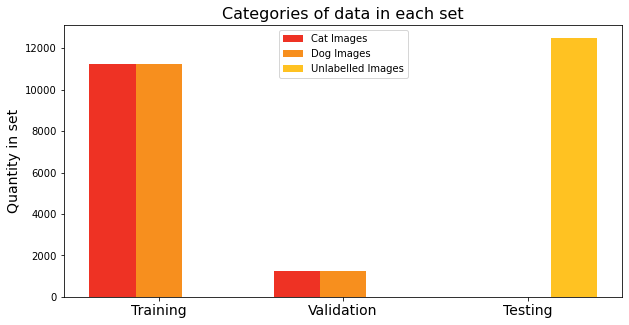

In [6]:
# Creating the data to plot
data_sets = ['Training', 'Validation', 'Testing']
cats = [len_train_cats, len_valid_cats, 0]
dogs = [len_train_dogs, len_valid_dogs, 0]
unlabelled = [0, 0, len_test]
labels = ['Cat Images', 'Dog Images', 'Unlabelled Images']

# Set position and width of bars
pos = list(range(len(data_sets)))
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with cat data in position pos
plt.bar(pos, cats, width, alpha=1, color='#EE3224', label=labels[0]) 

# Create a bar with dogs data in position pos + some width buffer,
plt.bar([p + width for p in pos], dogs, width, alpha=1, color='#F78F1E', label=labels[1]) 

# Create a bar with unlabelled data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], unlabelled, width, alpha=1, color='#FFC222', label=labels[2]) 

# Set the y axis label
ax.set_ylabel('Quantity in set', fontsize=14)

# Set the chart's title
ax.set_title('Categories of data in each set', fontsize=16)

# Set the position of the x ticks
ax.set_xticks([p + width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(data_sets, fontsize=14)

# Remove grid lines
ax.grid(None)

# Adding the legend and showing the plot
plt.legend(labels, loc='upper center')
plt.grid()
plt.show()                       

### Sampling Images
We can also take a look at the images in the data sets. 
If we look only at the dogs we can see that there are many different dog breeds of different colours and sizes in different poses. Some are even cropped and some have people in the images too, which makes them more compositionally complex. 

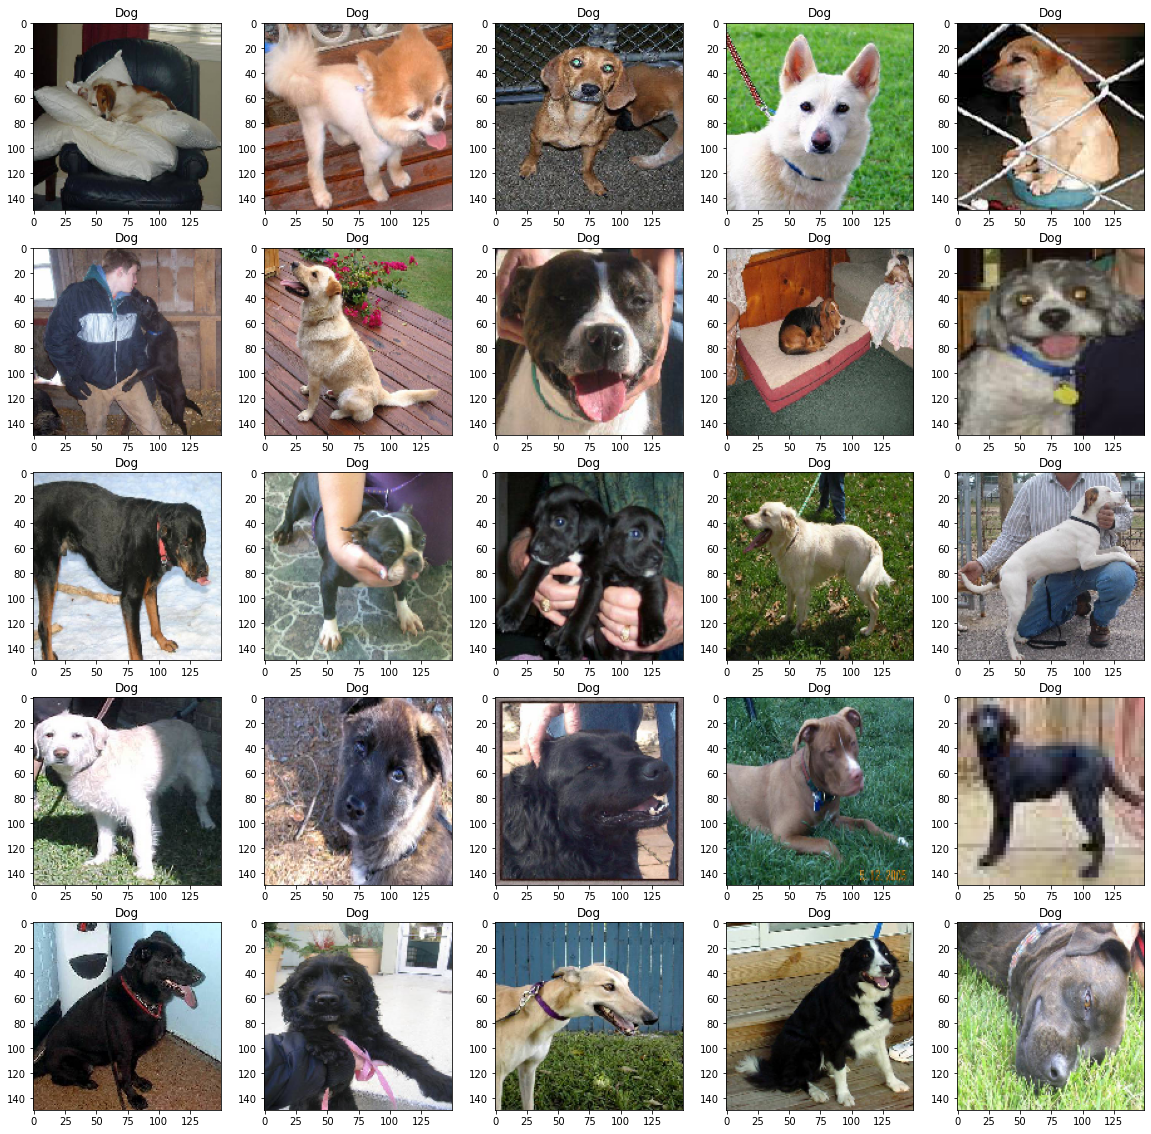

In [29]:
# Plotting images of only dogs

dimensions = 5

fig, axs = plt.subplots(dimensions, dimensions, figsize=(dimensions * 4, dimensions * 4))
for i in range(0, dimensions * dimensions):
    
    doggy_id = os.listdir(train_dogs)[i]
    
    row = i // dimensions
    col = i % dimensions
    img_PIL = Image.open(train_dogs+doggy_id)
    im_resized = img_PIL.resize((150,150))
    ax = axs[row][col]
    ax.imshow(im_resized)
    ax.set_title("Dog")

## 5. Augmentations with ImageGenerators

Now that we have sorted our data into subdirectories and confirmed that there is a good split of cats and dogs in each data set we will use ImageDataGenerator to load the data into the model. We can use this Generator to easily perform augmentations on the fly. I have normalised the images in all datasets by rescaling the pixel values (from 0 - 255 to 0 - 1). I have added several different rotations, image shifts, flips and zooms which should help to amplify the training data by simulating dogs of different sizes, angles and positions. 

In [8]:
# Adding augmentations with datagenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_gen = ImageDataGenerator(
    rescale=1./255)

test_gen = ImageDataGenerator(
    rescale=1./255)

# Creating generators
train_generator = train_gen.flow_from_directory(data_dir, batch_size=64, class_mode='binary', target_size=(150, 150))
valid_generator = valid_gen.flow_from_directory(valid_dir, batch_size=64, class_mode='binary', target_size=(150, 150))
test_generator = test_gen.flow_from_directory(test_dir_old, batch_size=64, class_mode='binary', shuffle=False, target_size=(150, 150))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## 6. Creating the Model

Next we can load a pretrained model for transfer learning. I am using InceptionV3 pretrained on imagenet because it is available automatically with keras. I am ending the model early at the 'mixed7 layer' and instead adding my own layers at the end, flattening the output and using densely connected layers to get a binary prediction of 1 for 'dog' or 0 for 'cat'. The pretrained layers are set to non-trainable while training on the final newly added layers still take place. 

In [9]:
# Pretrained model

# Loading InceptionV3 pretrained on imagenet
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights='imagenet')
    
# Removing the last layers of the model
last_layer = 'mixed7'
model = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer(last_layer).output)
model.summary()

# Creating a new model by adding different layers to the end of the cropped pre-trained model
new_model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setting the pretrained model to non-trainable
new_model.layers[0].trainable = False
new_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_____________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 768)         8975264   
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              38536192  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 47,512,481
Trainable params: 38,537,217
Non-trainable params: 8,975,264
_________________________________________________________________


## 7. Training

A learning rate reducer is added to optimise the learning rate during training and the model is compiled.

The metrics of the data fitting process for both the validation and training sets are visualised below.

Interestingly the validation metrics are better than the training set - perhaps due to the small sample size and augmentations only applied to the train set.

In [10]:
# Add a learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
# Compiling the model
new_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Training
NUM_EPOCHS = 3 
history = new_model.fit(train_generator, steps_per_epoch=len_train/64, epochs=NUM_EPOCHS, validation_data=(valid_generator), validation_steps=len_valid/64, callbacks=[learning_rate_reduction], verbose=1)

Epoch 1/3
352/351 [==============================] - 290s 825ms/step - loss: 0.4786 - accuracy: 0.8961 - val_loss: 0.0878 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 2/3
352/351 [==============================] - 288s 817ms/step - loss: 0.1872 - accuracy: 0.9292 - val_loss: 0.0713 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 3/3
352/351 [==============================] - 288s 817ms/step - loss: 0.1711 - accuracy: 0.9338 - val_loss: 0.0826 - val_accuracy: 0.9740 - lr: 0.0010


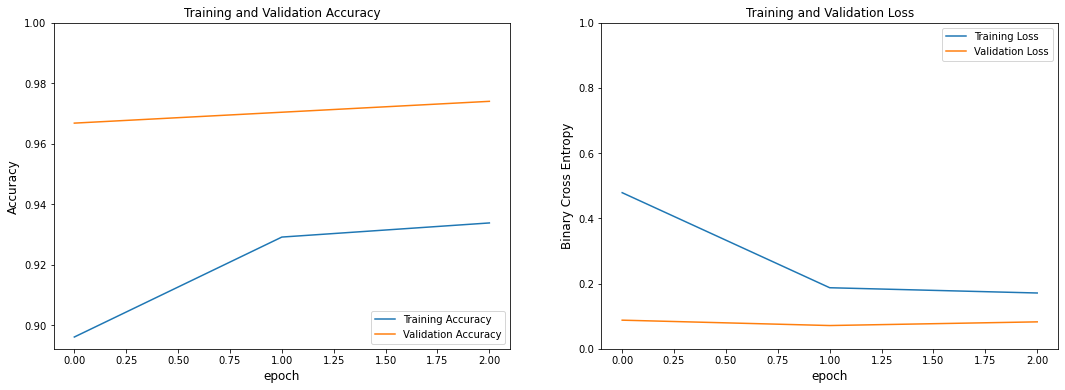

In [37]:
# Metrics

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting accuracy
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch', fontsize=12)

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy', fontsize=12)
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch', fontsize=12)
plt.show()


## 8. Inference

Now that the model is trained we can use it to make predictions of the contents of the images for the test set. 
With 3 epochs training we saw that the validation and training graph's hadn't converged, and more training might have improved the model. However, we still get a pretty good results for log loss on the test set: 0.212. 

In [13]:
# Predicting the test image classes
predictions = new_model.predict(test_generator)

In [15]:
# Converting the output predictions to the submission format for scoring
predictions_list = predictions.tolist()
for index, item in enumerate(predictions_list):
    predictions_list[index] = float(item[0])
    
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predictions_list)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head(20)

id         label
0       1  1.000000e+00
3612    2  1.000000e+00
4723    3  1.000000e+00
5834    4  1.000000e+00
6945    5  1.115370e-05
8056    6  2.005629e-04
9167    7  1.093259e-11
10278   8  3.280567e-06
11389   9  1.275845e-07
1      10  1.698983e-03
1112   11  1.192188e-09
2223   12  9.999996e-01
2835   13  2.175738e-09
2946   14  2.003420e-02
3057   15  1.922633e-06
3168   16  2.766254e-06
3279   17  9.999664e-01
3390   18  1.000000e+00
3501   19  3.755650e-11
3613   20  1.726284e-05

## 9. Evaluating the Results

We can visualise the results of the model by plotting some of the images and comapring them to their class probabilities. Values close to 1 mean that the model is very confident that the images is a dog. Values close to 0 mean that the model is confident the image contains a cat. Values in the middle i.e. 0.5 occur when the model is very unsure which animal class the image contains. 

Looking at a selection of these images below we can see that there is high confidence in the class of many images.

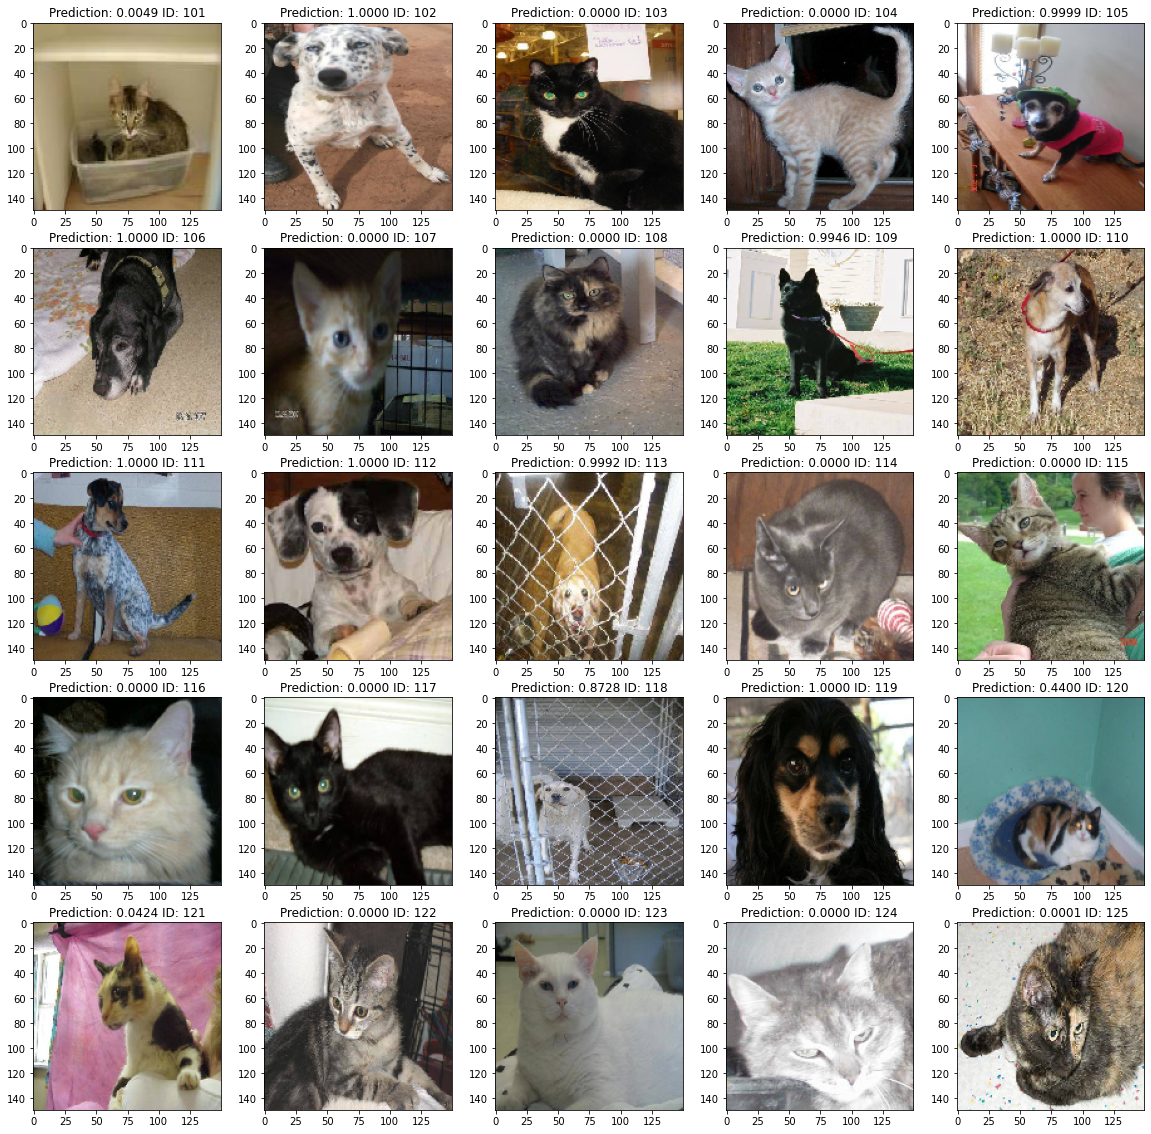

In [30]:
# Plotting the images and labelling with class predicitions
dimensions = 5
fig, axs = plt.subplots(dimensions, dimensions, figsize=(dimensions * 4, dimensions * 4))
for i in range(0, dimensions * dimensions):
    
    doggy_id = i + 1 +100
    
    row = i // dimensions
    col = i % dimensions
    img_PIL = Image.open(test_dir_new+ f"{doggy_id}.jpg")
    im_resized = img_PIL.resize((150,150))
    ax = axs[row][col]
    ax.imshow(im_resized)
    ax.set_title(f"Prediction: {results_df.label[results_df.id == doggy_id].values[0]:.4f} ID: {doggy_id}")

Next we can look at how the prediction values are spread. The histogram plot below shows high confidence in the majority of the images classes (i.e. 1 or 0). 
However, there is a small spread of low confidence images in between these two histogram columns. 

Why do these images confuse the model?

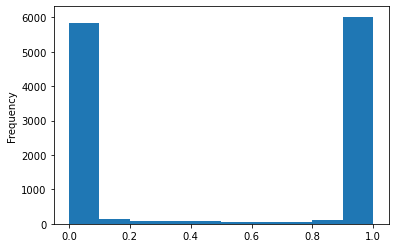

In [17]:
ax = results_df['label'].plot.hist(bins=10, alpha=1)

Sorting the data to find the images with the lowest confidence is achieved by subtracting 0.5 from each class probability and sorting in ascending order. Images with values closes to 0.5 now appear at the top of the list, these are the images that the model had no idea which class it was. Next we can plot these images and take a look to see where the model was going wrong. 

These images do seem much more difficult, there are some images which contain composite figures or text, very zoomed out cropped images, drawings of animals, images with many animals, pets wearing clothes and even some images which are not of animals at all. 

In [20]:
sorted_list = results_df
sorted_list['uncertainty'] = abs(sorted_list['label']-0.5)
sorted_list = sorted_list.sort_values(by = ['uncertainty'])
sorted_list = sorted_list.reset_index(drop=True)
sorted_list.head(10)

id     label  uncertainty
0   1621  0.499890     0.000110
1   8509  0.499612     0.000388
2   4876  0.501374     0.001374
3  12370  0.502970     0.002970
4   5419  0.496937     0.003063
5   8691  0.504137     0.004137
6    934  0.494834     0.005166
7   8055  0.509105     0.009105
8    200  0.510058     0.010058
9   6582  0.511093     0.011093

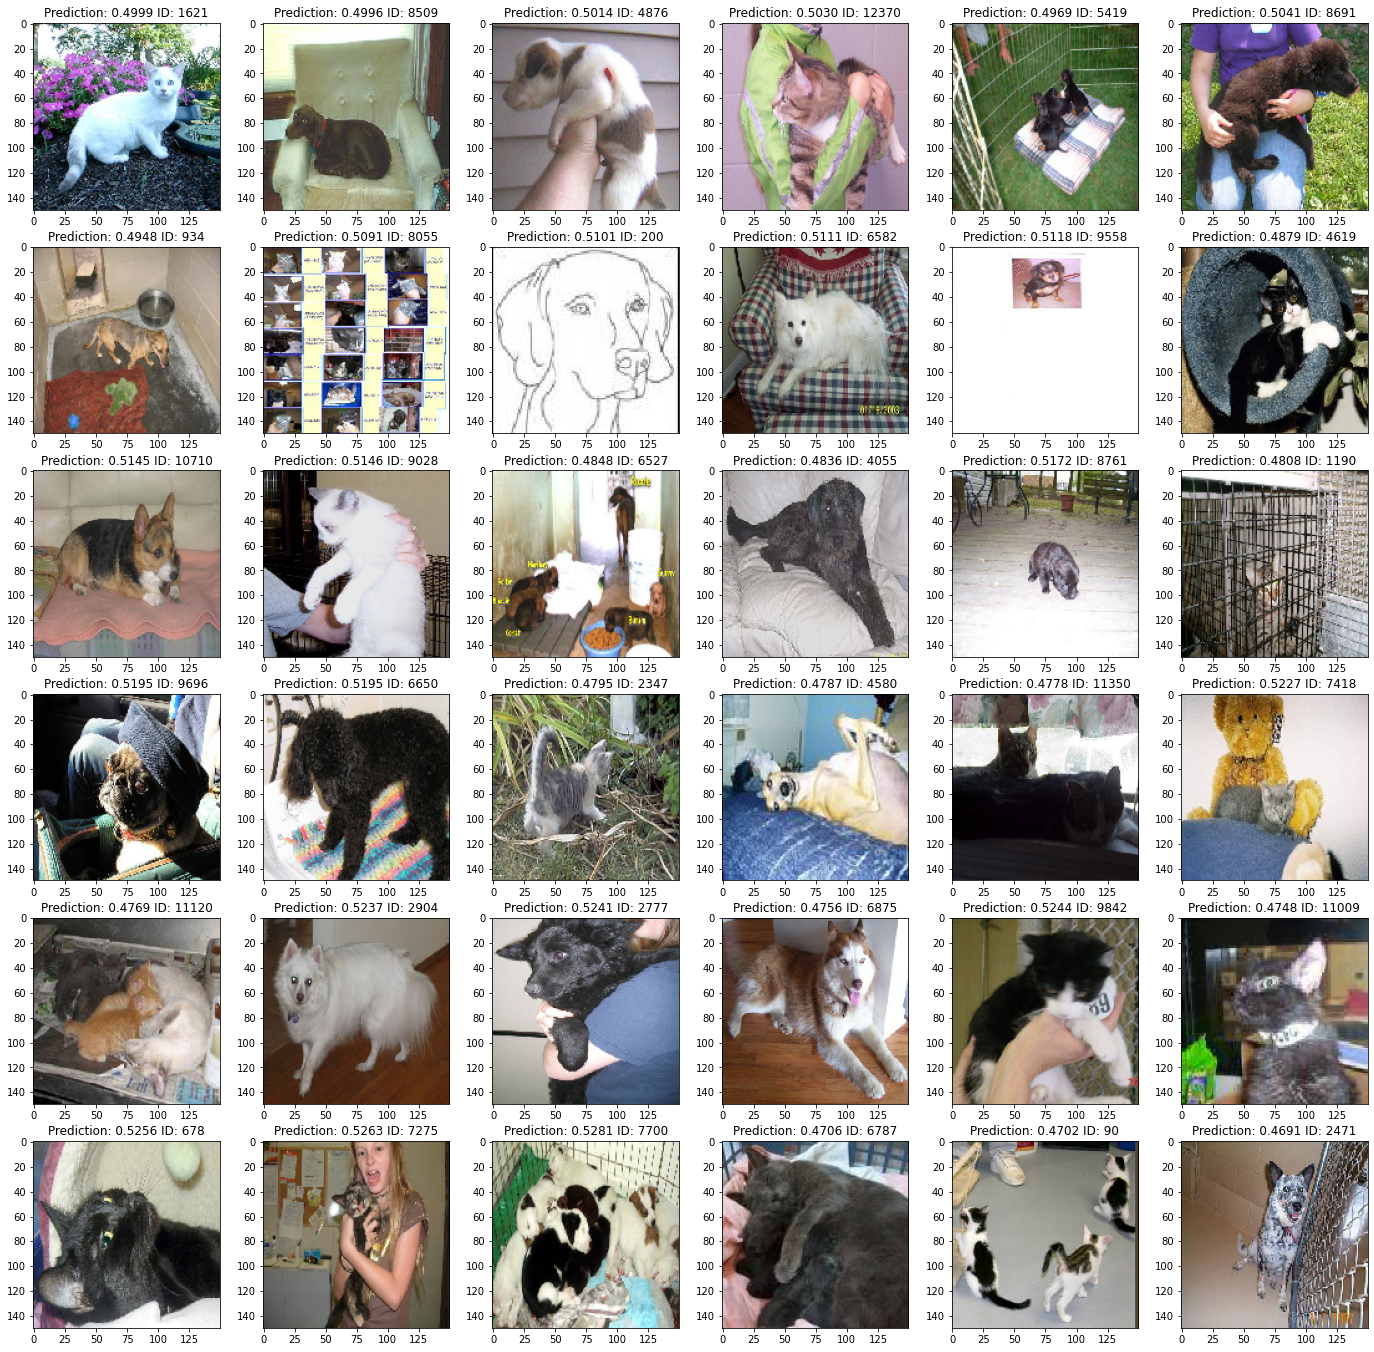

In [31]:
dimensions = 6
from PIL import Image
fig, axs = plt.subplots(dimensions, dimensions, figsize=(dimensions * 4, dimensions * 4))
for i in range(0, dimensions * dimensions):
    
    doggy_id = sorted_list.id[i]
    
    row = i // dimensions
    col = i % dimensions
    img_PIL = Image.open(test_dir_new+ f"{doggy_id}.jpg")
    im_resized = img_PIL.resize((150,150))
    ax = axs[row][col]
    ax.imshow(im_resized)
    ax.set_title(f"Prediction: {sorted_list.label[sorted_list.id == doggy_id].values[0]:.4f} ID: {doggy_id}")

## 10. Conclusions

* Using a pretrained model with some small modifications, we can get a really good result with only 3 epochs training. 

* We took a look at which images the model was unsure of and these were of animals in unusual positions and image compositions. The model would probably really benefit from more training with more augmentatations:


1. A bigger zoom range to replicate the cropped images/white space images.
2. Blur to replicate the low resolution images.
3. Making more composite images by combining different figures.
4. Geater rotations/sheers to replicate pets in unusual positions. 


* Manually removing the 'bad' images from the training set i.e. those which are not of cats and dogs would probably be beneficial to training too. However, because these images are also found in the test set (which is likely considering that the test and train sets are both very large) then it may not help to improve score too much. 

I hope you enjoyed reading this starter notebook and eda. Hopefully you can replicate the work and try to improve the model by applying more augmentations or modifying the model in other ways. 